# Create the GT image

In [13]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from scripts.despeckle import SARDespeckling
from scripts.texture_descriptor import rgb2gray, rgb2lab
import jax
import jax.numpy as jnp

print(jax.devices())

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


[cuda(id=0)]


In [2]:
input_dir = '/home/nus/Downloads/optical_sar_fusion/'
opt_dir = os.path.join(input_dir, 'opt')
sar_dir = os.path.join(input_dir, 'sar')
gt_dir = os.path.join(input_dir, 'gt')

filenames = []
for filename in os.listdir(sar_dir):
    if filename.endswith('.png'):
        filenames.append(os.path.join(sar_dir, filename))

print(len(filenames))

29


In [ ]:
imgs = [np.array(Image.open(f)) for f in filenames]

In [11]:
ystart, yend, xstart, xend = 50, 625, 100, -1

opt = np.array(Image.open(os.path.join(opt_dir, 'opt.png')))[ystart:yend, xstart:xend]
sar = imgs[0][ystart:yend, xstart:xend]
gt = np.array(Image.open(os.path.join(gt_dir, 'gt.png')))[ystart:yend, xstart:xend]

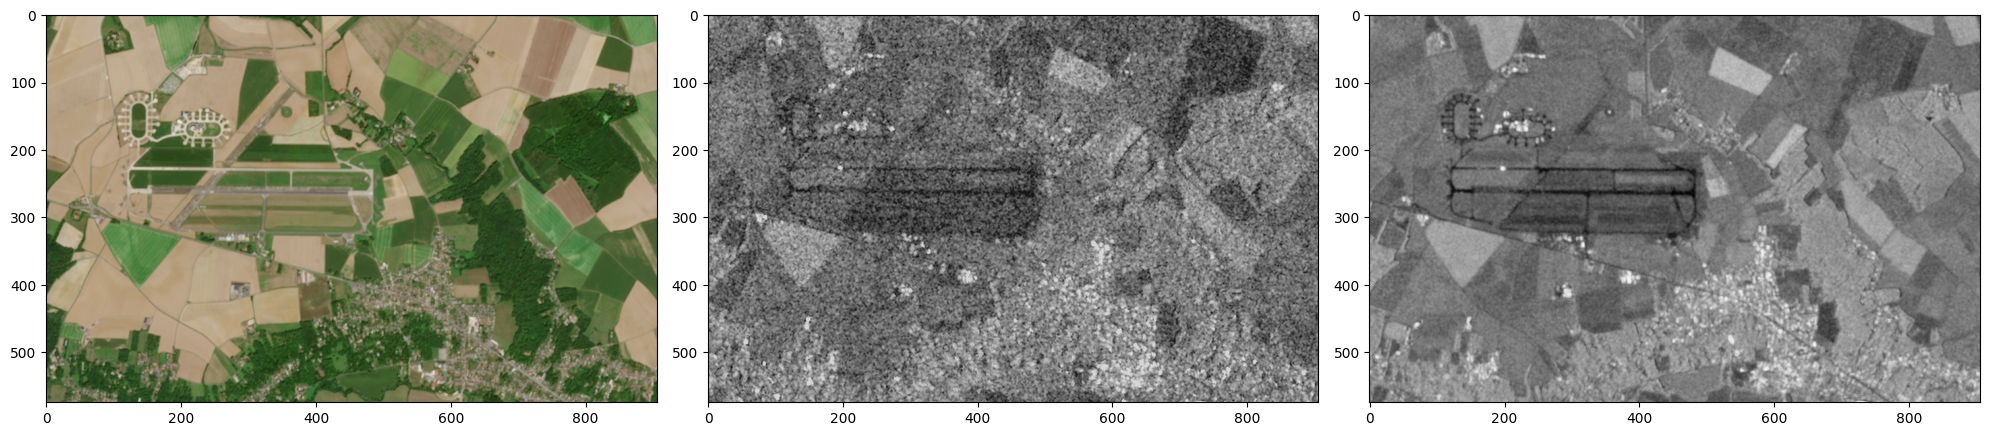

In [12]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.imshow(opt)
plt.subplot(1,3,2)
plt.imshow(sar, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(gt, cmap='gray')
plt.tight_layout()

In [14]:
sar_despeckling = SARDespeckling()

guide = opt.mean(axis=-1)[..., None] / 255.0
noisy = sar[..., None] / 255.0  # Normalize to [0, 1]

opt_gray = guide
sar = noisy

print(sar.shape, opt_gray.shape)

(575, 906, 1) (575, 906, 1)


In [15]:
params_texture_descriptor = {
    'opt': opt_gray,
    'radius': 7,
}

S = sar_despeckling._step1_compute_texture_descriptor(**params_texture_descriptor)

INFO:root:Computing texture descriptor...
2025-09-15 16:25:48.213352: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.8 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
INFO:root:Texture descriptor computed in 7.73 seconds.


In [16]:
params_mubf = {
    'target': S,
    'guides': [opt_gray, sar],  # (H, W, 1)
    'sigma_spatial': 5,
    'sigma_guides': [0.001, 0.001],
    'alpha': 5,
    'n_iterations': 50,
    'n_blocks': 5
}

S_mubf = sar_despeckling._step2_filter_texture_descriptor(**params_mubf)

INFO:root:Filtering texture descriptor with MUBF...
Iterations: 100%|██████████| 50/50 [01:16<00:00,  1.54s/it]
INFO:root:Texture descriptor filtering completed in 77.44 seconds.


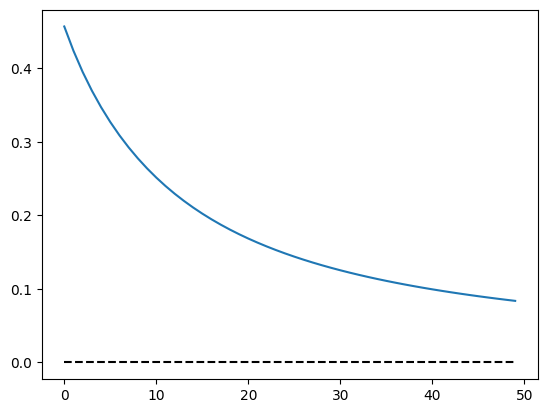

In [17]:
plt.plot(sar_despeckling.error)
plt.plot(np.arange(len(sar_despeckling.error)), np.zeros_like(sar_despeckling.error), 'k--')

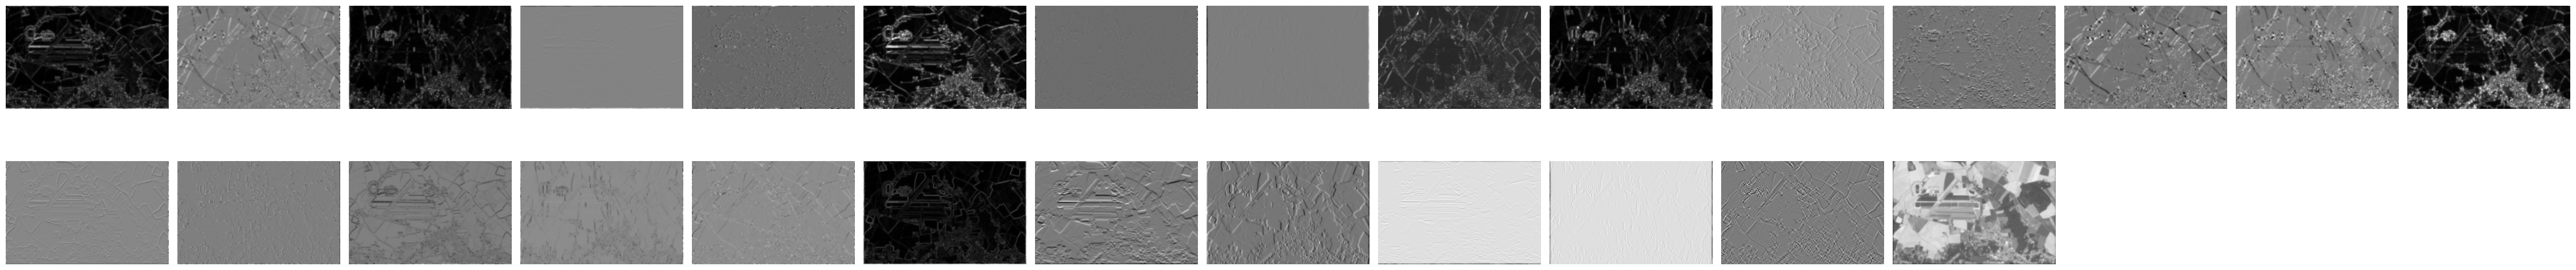

In [18]:
D = S_mubf.shape[-1]

N = 15  # Number of columns for plotting
plt.figure(figsize=(N * 3, (D // N + 1) * 3))
for i in range(D):
    plt.subplot(D // N + 1, N, i + 1)
    plt.imshow(S_mubf[:,:,i], cmap='gray')
    plt.axis('off')
plt.tight_layout()

In [19]:
params_despeckling = {
    "sar": sar,
    "descriptor": S_mubf,
    "sigma_distance": 0.02,
    "radius_despeckling": 15,
    "n_blocks": 10
}

sar_filtered = sar_despeckling._step3_despeckle(**params_despeckling)

INFO:root:Despeckling SAR image...
Despeckling: 100%|██████████| 100/100 [00:04<00:00, 24.43block/s]
INFO:root:Despeckling completed in 4.15 seconds.


In [24]:
# create a name based on the parameters
params_name = {
    'radius': params_texture_descriptor['radius'],
    'sigma_spatial': params_mubf['sigma_spatial'],
    'sigma_guides': str(params_mubf['sigma_guides'][0]) + '_' + str(params_mubf['sigma_guides'][1]),
    'alpha': params_mubf['alpha'],
    'n_iterations': params_mubf['n_iterations'],
    'sigma_distance': params_despeckling['sigma_distance'],
    'radius_despeckling': params_despeckling['radius_despeckling']
}

name = '_'.join([f'{k}-{v}' for k, v in params_name.items()])
name = 'tbog_' + name
name

'tbog_radius-7_sigma_spatial-5_sigma_guides-0.001_0.001_alpha-5_n_iterations-50_sigma_distance-0.02_radius_despeckling-15'

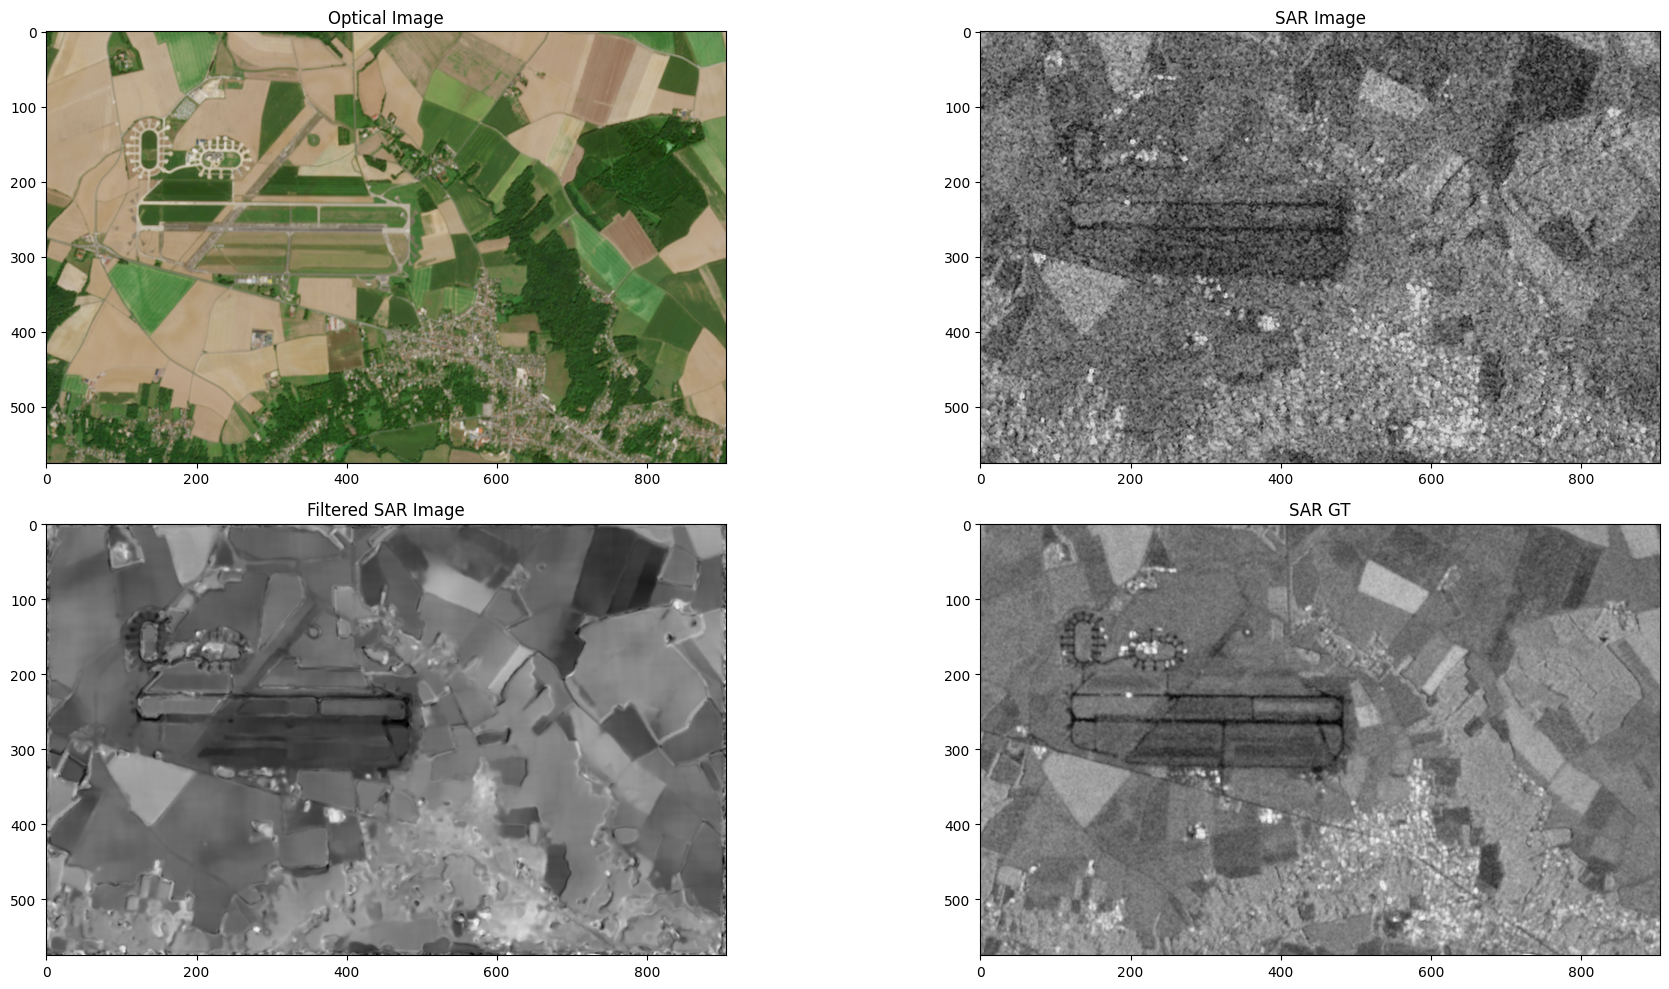

In [25]:
output_dir = os.path.join(input_dir, 'despeckling_results')

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.imshow(opt)
plt.title('Optical Image')
plt.subplot(2, 2, 2)
plt.imshow(sar, cmap='gray')
plt.title('SAR Image')
plt.subplot(2, 2, 3)
plt.imshow(sar_filtered, cmap='gray')
plt.title('Filtered SAR Image')
plt.subplot(2, 2, 4)
plt.imshow(gt, cmap='gray')
plt.title('SAR GT')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f'{name}.png'), dpi=300)